In [18]:
# Base
import itertools
from glob import glob

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader

# Local
from model import Generator, MultiPeriodDiscriminator, MultiScaleDiscriminator, feature_loss, generator_loss, discriminator_loss
from utils import dict_to_object, plot_specgram, plot_waveform
from dataset import SimpleAudioDataset
from audio import spectogram, load_mono_audio

# SuperVoice welcome notebook
This notebook contains various trash code i am using during exploration, nothing to see here, but just in case someone would want to see

In [2]:
config = dict_to_object({
    "resblock": "1",
    "num_gpus": 1,
    "batch_size": 16,
    "learning_rate": 0.0002,
    "adam_b1": 0.8,
    "adam_b2": 0.99,
    "lr_decay": 0.999,
    "seed": 42,

    "upsample_rates": [8,8,2,2],
    "upsample_kernel_sizes": [16,16,4,4],
    "upsample_initial_channel": 512,
    "resblock_kernel_sizes": [3,7,11],
    "resblock_dilation_sizes": [[1,3,5], [1,3,5], [1,3,5]],

    # Audio Parameters
    "sampling_rate": 16000,
    "segment_size": 8192,
    "num_mels": 80,
    "num_freq": 1025,
    "n_fft": 1024,
    "hop_size": 256,
    "win_size": 1024
})

# Device
device = torch.device('cuda:0')

## Dataset

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/functional.py:660: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:874.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


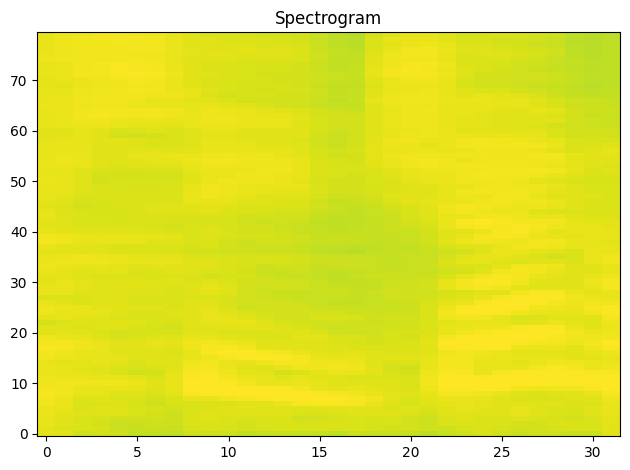

In [3]:
def transformer(audio):
    mel = spectogram(audio, config.n_fft, config.num_mels, config.hop_size, config.win_size, config.sampling_rate)
    return mel, audio
    
# Load dataset
training = SimpleAudioDataset(glob("external_datasets/lj-speech-1.1/wavs/*.wav"), config.sampling_rate, config.segment_size, transformer = transformer)

# Sample Spectogram
sample_spec, sample_wave = training[0]
plot_specgram(sample_spec)

In [4]:
# Model
epoch = -1
generator = Generator(config).to(device)
mpd = MultiPeriodDiscriminator().to(device)
msd = MultiScaleDiscriminator().to(device)
optim_g = torch.optim.AdamW(generator.parameters(), config.learning_rate, betas=[config.adam_b1, config.adam_b2])
optim_d = torch.optim.AdamW(itertools.chain(msd.parameters(), mpd.parameters()), config.learning_rate, betas=[config.adam_b1, config.adam_b2])
scheduler_g = torch.optim.lr_scheduler.ExponentialLR(optim_g, gamma=config.lr_decay, last_epoch=epoch)
scheduler_d = torch.optim.lr_scheduler.ExponentialLR(optim_d, gamma=config.lr_decay, last_epoch=epoch)

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [5]:
# Train
train_loader = DataLoader(training, 
                          num_workers=16, 
                          shuffle=False,
                          batch_size=config.batch_size,
                          pin_memory=True,
                          drop_last=True)
generator.train()
mpd.train()
msd.train()

MultiScaleDiscriminator(
  (discriminators): ModuleList(
    (0-2): 3 x DiscriminatorS(
      (convs): ModuleList(
        (0): Conv1d(1, 128, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): Conv1d(128, 128, kernel_size=(41,), stride=(2,), padding=(20,), groups=4)
        (2): Conv1d(128, 256, kernel_size=(41,), stride=(2,), padding=(20,), groups=16)
        (3): Conv1d(256, 512, kernel_size=(41,), stride=(4,), padding=(20,), groups=16)
        (4): Conv1d(512, 1024, kernel_size=(41,), stride=(4,), padding=(20,), groups=16)
        (5): Conv1d(1024, 1024, kernel_size=(41,), stride=(1,), padding=(20,), groups=16)
        (6): Conv1d(1024, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (conv_post): Conv1d(1024, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
  (meanpools): ModuleList(
    (0-1): 2 x AvgPool1d(kernel_size=(4,), stride=(2,), padding=(2,))
  )
)

In [6]:
for i, batch in enumerate(train_loader):

    # Load batch and move to GPU
    x, y = batch
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)
    y = y.unsqueeze(1) # Why is that?

    # Generate
    # Very weird way to generate and then zero grads, but not for this part? should be cleaned up
    y_g_hat = generator(x)
    y_g_hat_mel = spectogram(y_g_hat.squeeze(1), config.n_fft, config.num_mels, config.hop_size, config.win_size, config.sampling_rate)

    #
    # Discriminator Optimisation
    #
    
    optim_d.zero_grad()

    # MPD
    y_df_hat_r, y_df_hat_g, _, _ = mpd(y, y_g_hat.detach())
    loss_disc_f, losses_disc_f_r, losses_disc_f_g = discriminator_loss(y_df_hat_r, y_df_hat_g)

    # MSD
    y_ds_hat_r, y_ds_hat_g, _, _ = msd(y, y_g_hat.detach())
    loss_disc_s, losses_disc_s_r, losses_disc_s_g = discriminator_loss(y_ds_hat_r, y_ds_hat_g)

    loss_disc_all = loss_disc_s + loss_disc_f
    loss_disc_all.backward()
    optim_d.step()

    #
    # Generator Optimization
    #

    optim_g.zero_grad()

    # L1 Mel-Spectrogram Loss
    loss_mel = F.l1_loss(x, y_g_hat_mel) * 45

    # Discriminator-based losses
    y_df_hat_r, y_df_hat_g, fmap_f_r, fmap_f_g = mpd(y, y_g_hat)
    y_ds_hat_r, y_ds_hat_g, fmap_s_r, fmap_s_g = msd(y, y_g_hat)
    loss_fm_f = feature_loss(fmap_f_r, fmap_f_g)
    loss_fm_s = feature_loss(fmap_s_r, fmap_s_g)
    loss_gen_f, losses_gen_f = generator_loss(y_df_hat_g)
    loss_gen_s, losses_gen_s = generator_loss(y_ds_hat_g)
    loss_gen_all = loss_gen_s + loss_gen_f + loss_fm_s + loss_fm_f + loss_mel
    loss_gen_all.backward()
    optim_g.step()

    print(loss_mel.item())

81.48623657226562
74.46942138671875
62.91264343261719
57.6002311706543
63.5467414855957
57.67643737792969
57.04922866821289
54.550376892089844
51.79494857788086
55.170631408691406
56.451171875
50.37380599975586
51.604854583740234
47.86686325073242
48.799644470214844
45.15024185180664
47.39928436279297
45.45005416870117
45.9533805847168
46.28767013549805
46.541770935058594
47.896427154541016
43.926170349121094
41.72123336791992
43.64414978027344
42.436180114746094
39.98807144165039
41.13344955444336
42.27248001098633
39.193115234375
39.56626510620117
39.4951286315918
40.09317398071289
40.78056335449219
39.02871322631836
38.62954330444336
38.11809539794922
36.39094161987305
37.29743194580078
38.592594146728516
35.80574035644531
37.22309494018555
37.71027755737305
39.17854309082031
37.07942199707031
34.68064498901367
34.730342864990234
36.132015228271484
33.11591339111328
35.71615982055664
35.463905334472656
36.01126480102539
34.56242752075195
34.56017303466797
34.961490631103516
35.01950

# Evaluation

torch.Size([1, 154368]) torch.Size([154481])


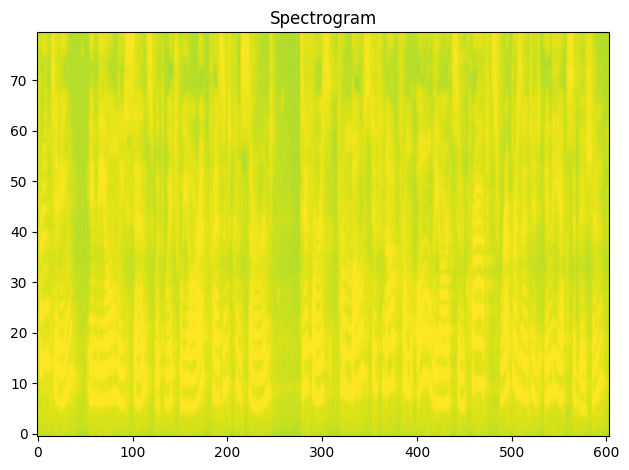

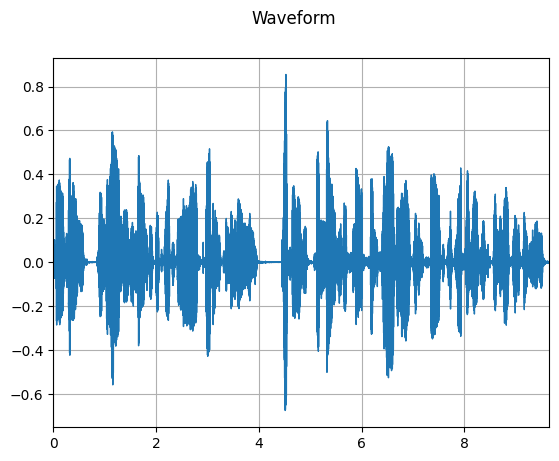

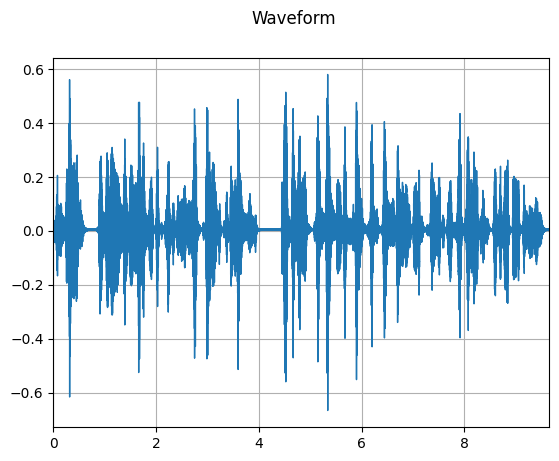

In [33]:
from IPython.display import Audio, display

# Load
test = load_mono_audio("./external_datasets/lj-speech-1.1/wavs/LJ001-0001.wav", config.sampling_rate)
spec = spectogram(test, config.n_fft, config.num_mels, config.hop_size, config.win_size, config.sampling_rate)

# Generate
generator.eval()
# generator.remove_weight_norm()
with torch.no_grad():
    resynth = generator(spec.unsqueeze(0).to(device)).squeeze(0).cpu()

print(resynth.shape, test.shape)

# Source
plot_specgram(spec)
plot_waveform(test.unsqueeze(0),xlim=(0,len(test) / config.sampling_rate))
plot_waveform(resynth,xlim=(0,len(test) / config.sampling_rate))
display(Audio(data=test, rate=config.sampling_rate))
display(Audio(data=resynth, rate=config.sampling_rate))